# Aligner Inference

This notebook will walk through the process of performing inference on an already-trained Aligner model.

TODO: Fill this in

In [1]:
# Start with some imports so we can visualize alignments and load the checkpoint
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import IPython.display as ipd

import librosa
import soundfile as sf
import torch

from nemo.collections.tts.models import AlignerModel
from omegaconf import OmegaConf

[NeMo W 2022-03-08 15:02:52 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


## Setup

Let's start by loading the checkpoint, which should have automatically been saved by the trainer as a file in the output directory's `checkpoints/` folder called `Aligner.nemo`.

Please update `ckpt_path` in the cell below to the appropriate location on your machine.

In [ ]:
# Set device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Replace the following with the path to your Aligner model checkpoint
ckpt_path = "~/Desktop/NeMo/nemo_experiments/Aligner/LJSpeech_CMUdict_Aligner_2022-02-16/checkpoints/Aligner.nemo"
aligner = AlignerModel.restore_from(ckpt_path, map_location=device)

# This should be set to whatever sample rate your model was trained on
target_sr = 22050

Now we'll load an audio file and input the corresponding transcript. The audio file will be resampled to the `target_sr` given above.

This example uses the first sample from the NVIDIA test split of LJSpeech, which is file `LJ023-0089.wav`. You can use whatever you'd like, of course, but this tutorial will refer to the text for this sample specifically for a concrete example.

If you'd like to download the LJSpeech dataset to use the same example, you can find it [here](https://keithito.com/LJ-Speech-Dataset/).

In [3]:
# This tutorial uses a sample from the NVIDIA test split of LJSpeech.
# Please change the following two lines to reflect your audio file and transcript.
audio_path = "/data3/LJSpeech/LJSpeech-1.1/wavs/LJ023-0089.wav"
text_raw = "That is not only my accusation."

# Load audio and resample if necessary
audio_data, orig_sr = sf.read(audio_path)
if orig_sr != target_sr:
    audio_data = librosa.core.resample(audio_data, orig_sr=orig_sr, target_sr=target_sr)

# Let's double-check that everything matches up!
print(f"Duration (s): {len(audio_data)/target_sr}")
print("Transcript:")
print(text_raw)
ipd.Audio(audio_data, rate=target_sr)

Duration (s): 2.6193650793650796
Transcript:
That is not only my accusation.


### Audio Preprocessing

The Aligner model takes in a mel spectrogram as input, so we'll need to convert our audio signal before we can evaluate it. The trained model has a preprocessor that will do this for us once we find the audio data length.

In [4]:
# Retrieve audio length for the model's preprocessor
audio_len = torch.tensor(audio_data.shape[0], device=device).long()

# Need to unsqueeze the audio data and audio_len to simulate a batch size of 1
audio = torch.tensor(audio_data, dtype=torch.float, device=device).unsqueeze(0)
audio_len = torch.tensor(audio_len).unsqueeze(0)
print(f"Audio batch shape: {audio.shape}")
print(f"Audio length shape: {audio_len.shape}\n")

# Generate the spectrogram!
spec, spec_len = aligner.preprocessor(input_signal=audio, length=audio_len)
print(f"Spec batch shape: {spec.shape}")

[NeMo W 2022-03-08 15:03:07 nemo_logging:349] /tmp/ipykernel_23117/2955961377.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
      audio_len = torch.tensor(audio_len).unsqueeze(0)
    


Audio batch shape: torch.Size([1, 57757])
Audio length shape: torch.Size([1])

Spec batch shape: torch.Size([1, 80, 226])


Let's take a look at the spectrogram to make sure it looks how we'd expect.

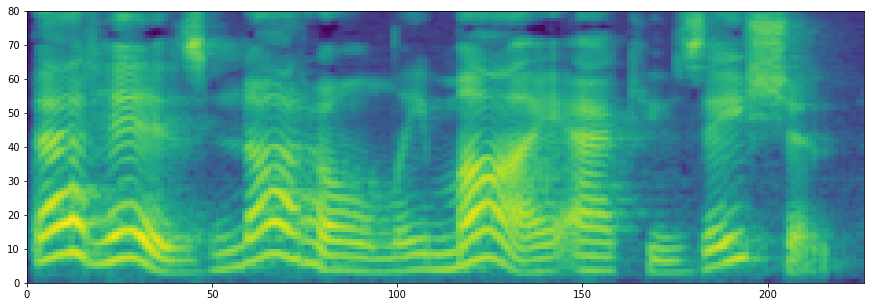

In [7]:
# Plot the spectrogram
plt.figure(figsize=(15,5))
plt.pcolormesh(spec[0].cpu().numpy(), cmap='viridis')

If the above looks like a spectrogram, we can move on to text preprocessing.

### Text Preprocessing

Now, we need to preprocess the text to be passed in to the model. This involves normalization, as well as conversion of the words in the transcript to phonemes where possible. OOV words, as well as words with multiple pronunciations, are ignored and kept as graphemes.

Let's take a look at these steps, one at a time.

In [8]:
# First, a standard English normalization of the text.
# Nothing too wild here!
text_normalized = aligner.normalizer.normalize(text_raw)
print(text_normalized)

That is not only my accusation .


At this point, we could normally just run the normalized text through the model's `tokenizer`, which would run G2P (grapheme to phoneme) conversion and spit out text tokens to pass into the model directly. But just to illustrate what happens within the tokenizer, let's take a look at its G2P step.

(If you are writing your own inference script, you can leave the code in this next cell out entirely, as it's purely illustrative.)

In [9]:
# The intermediate G2P step.
# This part is usually hidden behind just calling `tokenizer()`, but we show it here to illustrate what happens.
text_g2p = aligner.tokenizer.g2p(text_normalized)
print(text_g2p)
print(f"Length: {len(text_g2p)}")

['t', 'h', 'a', 't', ' ', 'i', 's', ' ', 'N', 'AA1', 'T', ' ', 'OW1', 'N', 'L', 'IY0', ' ', 'M', 'AY1', ' ', 'a', 'c', 'c', 'u', 's', 'a', 't', 'i', 'o', 'n', ' ', '.']
Length: 32


We can see that some words have been converted to phonemes (e.g. "not" turned into `["N", "AA1", "T"]`), while some have stayed as graphemes (e.g. "that" is still `["t", "h", "a", "t"]`). As mentioned above, this is because any words with unique and known pronunciations are converted, but other words may have multiple possible pronunciations. CMUdict lists three for "that": `"DH AE1 T"`/`"DH AH0 T"`.

The next cell shows what we'd normally run right after we normalize the text. This gets us our text tokens. (The length increases by 2 if `pad_with_space` was set for the model.)

In [10]:
# The tokenizer runs G2P and then encodes each token.
text_tokens = aligner.tokenizer(text_normalized)
print(text_tokens)
print(f"Length: {len(text_tokens)}")

# We need these to be torch tensors before passing them in as input, of course
text = torch.tensor(text_tokens, device=device).unsqueeze(0).long()
text_len = torch.tensor(len(text_tokens), device=device).unsqueeze(0).long()
print("\nAfter unsqueezing...")
print(f"Text input shape: {text.shape}")
print(f"Text length shape: {text_len.shape}")

[0, 89, 77, 70, 89, 0, 78, 88, 0, 12, 26, 18, 0, 59, 12, 10, 55, 0, 11, 41, 0, 70, 72, 72, 90, 88, 70, 89, 78, 84, 83, 0, 98, 0]
Length: 34

After unsqueezing...
Text input shape: torch.Size([1, 34])
Text length shape: torch.Size([1])


Now we have our audio data and encoded text!

## Inference: Alignments and Phoneme Disambiguation

Now that we have the audio and tokenized text, we can pass it through the trained model and get an alignment between the two inputs.

In [11]:
# Run the aligner!
with torch.no_grad():
    attn_soft_tensor, attn_logprob_tensor = aligner(spec=spec, spec_len=spec_len, text=text, text_len=text_len)

# "Unbatch" the results
attn_soft = attn_soft_tensor[0, 0, :, :].data.cpu().numpy()
attn_logprob = attn_logprob_tensor[0, 0, :, :].data.cpu().numpy()
print(f"Dimensions should be (spec_len={spec_len[0].data}, text_len={text_len[0].data}) for both:")
print(f"Soft attention matrix shape: {attn_soft.shape}")
print(f"Log prob matrix shape: {attn_logprob.shape}")

Dimensions should be (spec_len=226, text_len=34) for both:
Soft attention matrix shape: (226, 34)
Log prob matrix shape: (226, 34)


### Visualizing the Alignments

Now that we have the soft alignments, we can take a look at how the model matches up text tokens and audio input based on the attention matrix generated. This should roughly be a monotonically decreasing diagonal line (towards the bottom right).

In the following cell, we transpose the soft attention matrix before plotting it in order to show it more "naturally," that is, with the text along the vertical edge (Y-axis) and an increase in the X-axis (left-to-right) value corresponding with moving forward in time through the spectrogram.

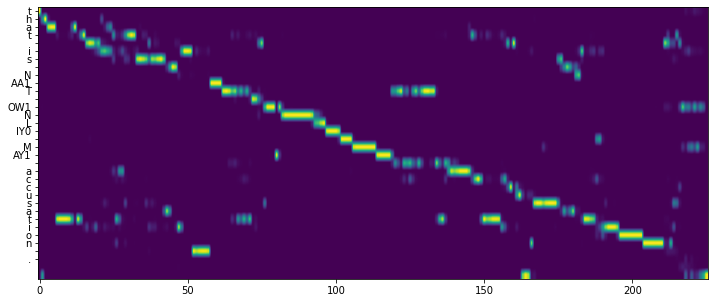

In [12]:
# Visualize soft attention matrix.
fig, ax = plt.subplots(figsize=(12,5))
_ = ax.imshow(attn_soft.transpose(), origin='upper', aspect='auto')
_ = ax.set_yticks(range(len(text_g2p)))
_ = ax.set_yticklabels(text_g2p)  # To show the text labels

The above is a soft attention matrix, so we can see that it is somewhat noisy.

We can calculate a hard attention matrix to get more concrete predictions for the durations of each grapheme/phoneme. The next plot should be much sharper. We'll show the spectrogram again so we get a rough idea of what alignments match up with what spectrogram features.

Hard attention matrix shape: (226, 34)


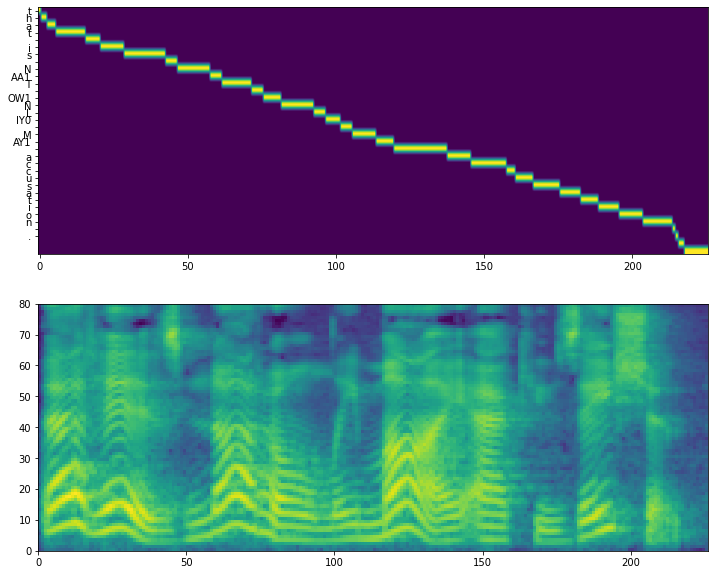

In [13]:
# Import helper function to calculate hard attention
from nemo.collections.tts.helpers.helpers import binarize_attention

attn_hard_tensor = binarize_attention(attn_soft_tensor, text_len, spec_len)
attn_hard = attn_hard_tensor[0, 0, :, :].data.cpu().numpy()
print(f"Hard attention matrix shape: {attn_hard.shape}")  # This should be the same as before!

# Now, let's plot the hard attention matrix.
fig, ax = plt.subplots(2, 1, figsize=(12,10))
_ = ax[0].imshow(attn_hard.transpose(), origin='upper', aspect='auto')
_ = ax[0].set_yticks(range(len(text_g2p)))
_ = ax[0].set_yticklabels(text_g2p)  # To show the text labels

_ = ax[1].pcolormesh(spec[0].cpu().numpy(), cmap='viridis')

### Calculating Token Durations

To get the duration (in frames) of each token, we would get the hard attention matrix, then sum up the number of frames that correspond to each token. Luckily, there is a function in the Aligner's encoder module that does this for us!

In [36]:
# Call function to calculate each token's duration in frames
durations = aligner.alignment_encoder.get_durations(attn_soft_tensor, text_len, spec_len).int()

# Let's match them up.
for t,d in zip(text_g2p, durations[0]):
    print(f"'{t}' duration: {d}")

# The following should be equal.
print(f"Total number of frames: {spec_len.item()}")
print(f"Sum of durations: {durations.sum().item()}")

cuda:0
't' duration: 1
'h' duration: 2
'a' duration: 3
't' duration: 10
' ' duration: 5
'i' duration: 8
's' duration: 14
' ' duration: 4
'N' duration: 11
'AA1' duration: 4
'T' duration: 10
' ' duration: 4
'OW1' duration: 6
'N' duration: 11
'L' duration: 4
'IY0' duration: 5
' ' duration: 4
'M' duration: 8
'AY1' duration: 6
' ' duration: 18
'a' duration: 8
'c' duration: 12
'c' duration: 3
'u' duration: 6
's' duration: 9
'a' duration: 7
't' duration: 6
'i' duration: 7
'o' duration: 8
'n' duration: 10
' ' duration: 1
'.' duration: 1
Total number of frames: 226
Sum of durations: 226


### Phoneme Disambiguation via Embedding Distance

Remember how some words were not converted in the G2P step, and were kept as graphemes because they had multiple possible pronunciations? It turns out that we can also use a trained Aligner model to make predictions for phoneme disambiguation!

We can do this by:

1. Generating one text input per possible pronunciation (e.g. one sentence with `"DH AE1 T"` and one with `"DH AH0 T"`)
2. Running inference on each (with the same spectrogram)
3. Calculating the distance between the text/spectrogram embeddings
4. Seeing which disambiguation tokens are closer to the spectrogram, as determined by the model.

---

Let's get started with our example! As a reminder, the original sentence we've used for this tutorial is:
```
That is not only my accusation.
```

In this sentence, "that," "is," and "accusation" have multiple entries in CMUdict. Each has two possible pronunciations, which means to disambiguate everything, we'd use six inputs:
```
# "that":
DH AE1 T   i s   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .
DH AH0 T   i s   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .

# "is":
t h a t   IH1 Z   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .
t h a t   IH0 Z   N AA1 T   OW1 N L IY0   M AY1   a c c u s a t i o n .

# "accusation":
t h a t   i s   N AA1 T   OW1 N L IY0   M AY1   AE2 K Y AH0 Z EY1 SH AH0 N .
t h a t   i s   N AA1 T   OW1 N L IY0   M AY1   AE2 K Y UW0 Z EY1 SH AH0 N .
```

For brevity's sake, let's just disambiguate the word `that`.

In [ ]:
# TODO: get two as lists in here
pron1 = []
pron2 = []

Next, we retrieve the L2 distance matrix between the text embedding and the spectrogram embedding. There is an alignment encoder function called `get_dist()` that will calculate `(text_emb[i] - spec_emb[j])^2` for all pairs of text tokens and spectrogram timesteps, and we can get the L2 distance matrix by square-rooting those values.

(Note that darker = smaller distance, so we should see a dark diagonal of a similar shape to the lines above.)

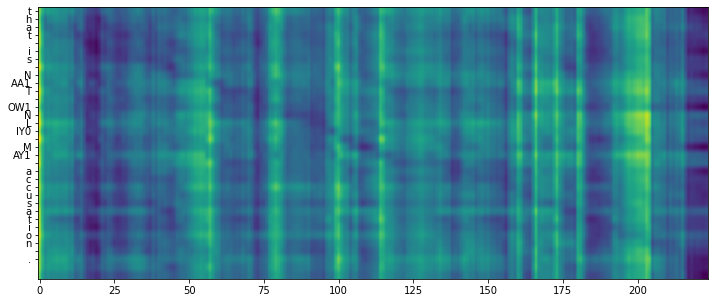

In [74]:
# TODO: update the vars in here for disambiguation

# Housekeeping: we first need to get the text embedding
text_emb = aligner.embed(text).transpose(1,2)

# Run the Aligner encoder to get the distances between the key (text) and query (spec) embeddings.
square_dists = aligner.alignment_encoder.get_dist(keys=text_emb, queries=spec)
l2_dists = square_dists.sqrt()

# We can plot the L2 distance now
l2_dists_data = dists.sqrt()[0, :, :].data.cpu().numpy()
fig, ax = plt.subplots(figsize=(12,5))
# (Here, we trim the first and last time steps for better visualization since the distance is much larger)
_ = ax.imshow(l2_dists_data[1:-1].transpose(), origin='upper', aspect='auto')
_ = ax.set_yticks(range(len(text_g2p)))
_ = ax.set_yticklabels(text_g2p)  # To show the text labels

As a side note, there is also a function called `get_mean_dist_by_durations()` that will match up the distances between each token and its corresponding spectrogram frame (using the previously-calculated durations), then calculate the mean over the batch.

In [73]:
# Mean distance over the batches:
# TODO: Update this for multiple batches (b/c disambiguation run)
mean_dists = aligner.alignment_encoder.get_mean_dist_by_durations(
    dist=l2_dists.to('cpu'),
    durations=durations.to('cpu')
)

print(mean_dists.item())

383.9185791015625


The average may not tell us very much here, because we just want to know which pronunciation is closest to what's being said for a specific word, not whether the whole sentence is close! 


In [ ]:
# Average b/c prons may be different length?